# Load Dataset and Pre-Processing

In [1]:
import re

import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

/home/xhd/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xhd/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xhd/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xhd/miniconda3/lib/python3.7/site-packages/tensorboard/compat

# Read Files and Fill NaN

In [2]:
lines_path = 'data/movie_lines.txt'
convs_path = 'data/movie_conversations.txt'

lines_df = pd.read_csv(lines_path,
                    sep='\s*\+\+\+\$\+\+\+\s*', 
                    engine='python',
                    header=None,
                    index_col=0)

lines_df.head()

,1,2,3,4
0,,,,
L1045,u0,m0,BIANCA,They do not!
L1044,u2,m0,CAMERON,They do to!
L985,u0,m0,BIANCA,I hope so.
L984,u2,m0,CAMERON,She okay?
L925,u0,m0,BIANCA,Let's go.


In [3]:
lines_df.isna().sum()

1      0
2      0
3     43
4    267
dtype: int64

In [4]:
lines_df.iloc[:, -1].fillna('', inplace=True)

In [5]:
lines_df.isna().sum()

1     0
2     0
3    43
4     0
dtype: int64

In [6]:
convs_df = pd.read_csv(convs_path,
                    sep='\s*\+\+\+\$\+\+\+\s*', 
                    engine='python',
                    header=None)

convs_df.head()

,0,1,2,3
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']"
1,u0,u2,m0,"['L198', 'L199']"
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']"
3,u0,u2,m0,"['L204', 'L205', 'L206']"
4,u0,u2,m0,"['L207', 'L208']"


In [7]:
convs_df.isna().sum()

0    0
1    0
2    0
3    0
dtype: int64

# Obtain Conversations

In [8]:
convs_data = []
for line_ids in tqdm(convs_df.iloc[:, -1], desc='Build'):
    conv = []
    for line_id in eval(line_ids):
        conv.append(lines_df.loc[line_id].iloc[-1])
    convs_data.append(conv)

## (Check Length of Conversations)

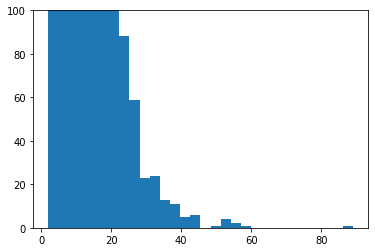

In [9]:
lens = [len(conv) for conv in convs_data]
plt.hist(lens, bins=30)
plt.ylim(0, 100)
plt.show()

# Clean Each Sentence and Tokenize

In [10]:
def clean(sent):
    sent = sent.lower().strip()
    sent = re.sub(r'[^a-zA-Z.!?]+', r' ', sent)
    sent = re.sub(r'([.!?])\1*', r' \1', sent)
    sent = re.sub(r'\s+', r' ', sent)
    sent = sent.strip().split()
    return sent

In [11]:
convs = []
for conv in tqdm(convs_data, desc='Clean'):
    convs.append(list(map(clean, conv)))

## (Check Length of Each Sentence )

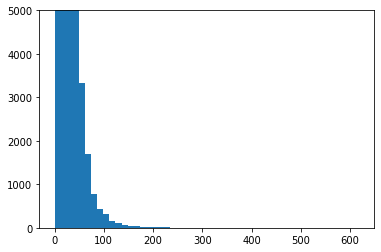

In [12]:
lens = []
for conv in convs:
    for sent in conv:
        lens.append(len(sent))
plt.hist(lens, bins=50)
plt.ylim(0, 5000)
plt.show()

In [13]:
lens_short = [x for x in lens if x <= 30]
print(len(lens_short), len(lens), len(lens_short) / len(lens))

281094 304713 0.9224877179509899


# Make Sentence Pairs and Filter

In [14]:
pairs = []
for conv in convs:
    for i in range(len(conv) - 1):
        pairs.append((conv[i], conv[i + 1]))
        
print(len(pairs))

221616


In [15]:
def filter_pairs(pairs, min_length):
    pairs_short = []
    for a, b in pairs:
        if len(a) > 0 and len(a) <= MIN_LENGTH \
            and len(b) > 0 and len(b) <= MIN_LENGTH:
            pairs_short.append((a, b))
    return pairs_short


MIN_LENGTH = 30
pairs = filter_pairs(pairs, MIN_LENGTH)

print(len(pairs))
print(pairs[0][0])
print(pairs[0][1])

188774
['can', 'we', 'make', 'this', 'quick', '?', 'roxanne', 'korrine', 'and', 'andrew', 'barrett', 'are', 'having', 'an', 'incredibly', 'horrendous', 'public', 'break', 'up', 'on', 'the', 'quad', '.', 'again', '.']
['well', 'i', 'thought', 'we', 'd', 'start', 'with', 'pronunciation', 'if', 'that', 's', 'okay', 'with', 'you', '.']


In [16]:
convs_data[0]

['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.',
 "Well, I thought we'd start with pronunciation, if that's okay with you.",
 'Not the hacking and gagging and spitting part.  Please.',
 "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?"]

# Make Vocabulary

In [17]:
class Vocab:
    
    def __init__(self):
        self.special_tokens = ['<pad>', '<eos>', '<unk>']
        self.word_count = {}
        self.index2word = []
        self.word2index = {}
        
    def add_word(self, word):
        if word in self.word_count:
            self.word_count[word] += 1
        else:
            self.word_count[word] = 1
            
    def make_vocab(self, size):
        self.word_count = sorted(self.word_count, key=self.word_count.get, reverse=True)
     
        for w in self.special_tokens + self.word_count[:size]:
            self.index2word.append(w)
            self.word2index[w] = len(self.index2word) - 1
                
    def __len__(self):
        return len(self.index2word)
                
    def __getitem__(self, query):
        if isinstance(query, int):
            return self.index2word[query]
        if isinstance(query, str):
            if query in self.word2index:
                return self.word2index[query]
            else:
                return self.word2index['<unk>']

## (Test Vocab)

In [18]:
a = ['a', 'boy', 'cow', 'and', 'a', 'boy', 'a']

vocab = Vocab()
for word in a:
    vocab.add_word(word)
print(vocab.word_count)

vocab.make_vocab(size=3)

print(vocab.index2word)
print(vocab.word2index)
print(len(vocab))
print(vocab[4])
print(vocab['<eos>'])
print(vocab['abc'])

{'a': 3, 'boy': 2, 'cow': 1, 'and': 1}
['<pad>', '<eos>', '<unk>', 'a', 'boy', 'cow']
{'<pad>': 0, '<eos>': 1, '<unk>': 2, 'a': 3, 'boy': 4, 'cow': 5}
6
boy
1
2


# Build Vocabuary

In [19]:
vocab = Vocab()
for i in range(len(pairs) - 1):
    if pairs[i][1] == pairs[i + 1][0]:
        words = pairs[i][0]
    else:
        words = pairs[i][0] + pairs[i][1]
    for word in words:
        vocab.add_word(word)
        
print(len(vocab.word_count))

41034


## (Check Word Count)

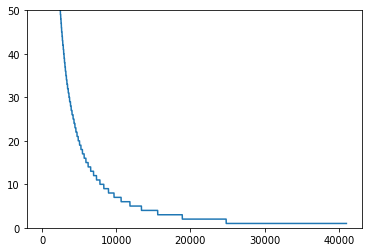

In [20]:
a = sorted(vocab.word_count.values(), reverse=True)
plt.plot(a)
plt.ylim(0, 50)
plt.show()

In [21]:
print(a[10000])

7


In [22]:
VOCAB_SIZE = 10000
vocab.make_vocab(size=VOCAB_SIZE)

In [23]:
len(vocab)

10003

# Build Dataset

In [24]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, pairs, vocab):
        self.pairs = pairs
        self.vocab = vocab
    
    def __getitem__(self, index):
        x, y = self.pairs[index]
        x = [vocab[w] for w in x]
        y = [vocab[w] for w in y] + [vocab['<eos>']]
        return x, y
    
    def __len__(self):
        return len(self.pairs)

In [25]:
dataset = Dataset(pairs, vocab)

print(len(dataset))
print(pairs[0][0])
print(dataset[0][0])
print(pairs[0][1])
print(dataset[0][1])
print(vocab.index2word[:20])

188774
['can', 'we', 'make', 'this', 'quick', '?', 'roxanne', 'korrine', 'and', 'andrew', 'barrett', 'are', 'having', 'an', 'incredibly', 'horrendous', 'public', 'break', 'up', 'on', 'the', 'quad', '.', 'again', '.']
[39, 20, 115, 26, 886, 6, 2, 2, 17, 4306, 6942, 37, 418, 85, 3831, 2, 1189, 496, 57, 35, 7, 2, 3, 185, 3]
['well', 'i', 'thought', 'we', 'd', 'start', 'with', 'pronunciation', 'if', 'that', 's', 'okay', 'with', 'you', '.']
[61, 5, 144, 20, 78, 323, 41, 2, 55, 13, 9, 107, 41, 4, 3, 1]
['<pad>', '<eos>', '<unk>', '.', 'you', 'i', '?', 'the', 'to', 's', 'it', 'a', 't', 'that', 'what', '!', 'of', 'and', 'me', 'in']


# Collate Function

In [26]:
def collate_fn(batch):
    batch_x, batch_y = [], []
    for x, y in batch:
        batch_x.append(torch.tensor(x))
        batch_y.append(torch.tensor(y))
    batch_x = torch.nn.utils.rnn.pad_sequence(batch_x, padding_value=0)    
    batch_y = torch.nn.utils.rnn.pad_sequence(batch_y, padding_value=0)
    return batch_x, batch_y


batch = [
    ([1, 2, 3], [1, 2]),
    ([1], [1, 2, 3]),
]

batch_x, batch_y = collate_fn(batch)
print(batch_x)
print(batch_y)

tensor([[1, 1],
        [2, 0],
        [3, 0]])
tensor([[1, 1],
        [2, 2],
        [0, 3]])


In [27]:
x = batch_x

((x != 0).sum(dim=0) <= 2).int()

tensor([0, 1], dtype=torch.int32)

# DataLoader

In [28]:
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=4,
    collate_fn=collate_fn,
)

In [29]:
a = next(iter(data_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([25, 4])
torch.Size([17, 4])


# Model

In [30]:
class Encoder(torch.nn.Module):
    
    def __init__(self, embed, hidden_size, pad_value):
        super(Encoder, self).__init__()
        self.pad_value = pad_value
        self.embed = embed
        self.lstm = torch.nn.LSTM(
            input_size=embed.embedding_dim,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
        )
        
    def forward(self, x):
        lengths = (x != self.pad_value).sum(dim=0)
        x = self.embed(x)
        x = torch.nn.utils.rnn.pack_padded_sequence(
            x, lengths, enforce_sorted=False)
        output, (h, c) = self.lstm(x)
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(
            output, padding_value=self.pad_value)
        return output, (h.mean(dim=0), c.mean(dim=0))

    
vocab_size = 10
embed_size = 5
batch_size = 4
hidden_size = 4

embed = torch.nn.Embedding(len(vocab), embed_size)
encoder = Encoder(embed, hidden_size, pad_value=0)
batch_x, batch_y = next(iter(data_loader))
contex, (h, c) = encoder(batch_x)
print(contex.shape, h.shape, c.shape)

torch.Size([25, 4, 8]) torch.Size([4, 4]) torch.Size([4, 4])


In [31]:
class Decoder(torch.nn.Module):
    
    def __init__(self, embed, hidden_size, start_token):
        super(Decoder, self).__init__()
        self.start_token = start_token
        self.embed = embed
        self.lstm_cell = torch.nn.LSTMCell(
            embed.embedding_dim, hidden_size)
        self.out = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, embed.num_embeddings),
        )
        
    def forward(self, hidden, contex, y):
        y_preds = []
        h, c = hidden
        x = torch.empty(*y.size()[1:], dtype=torch.long)
        x = x.fill_(self.start_token)
        for i in range(len(y)):
            x = self.embed(x)
            h, c = self.lstm_cell(x, (h, c))
            y_pred = self.out(torch.cat([h, c], dim=1))
            y_preds.append(y_pred)
            x = y[i]
        return torch.stack(y_preds)

In [32]:
class Seq2Seq(torch.nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, 
                 pad_value, start_token):
        super(Seq2Seq, self).__init__()
        self.embed = torch.nn.Embedding(vocab_size, embed_size)
        self.encoder = Encoder(embed, hidden_size, pad_value)
        self.decoder = Decoder(embed, hidden_size, start_token)
        
    def forward(self, x, y):
        contex, (h, c) = self.encoder(x)
        y_preds = self.decoder((h, c), contex, y)
        return y_preds

In [37]:
class Trainer:
    
    def __init__(self, model, train_dataloader, n_epoch, optim, tb_dir=None, 
                 case_interval=None, vocab=None,
                 valid_dataloader=None, test_dataloader=None):
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.test_dataloader = test_dataloader
        self.n_epoch = n_epoch
        self.optim = optim
        self.case_interval = case_interval
        self.vocab = vocab
        self.writer = SummaryWriter(tb_dir, flush_secs=1) if tb_dir else None
        
    def loss_fn(self, input, target):
        input = input.reshape(-1, input.size(-1))
        target = target.reshape(-1)
        
        loss = torch.nn.functional.cross_entropy(
            input=input, target=target,
            ignore_index=0, reduction='mean')
        return loss
    
    def batch2sents(self, batch):
        sents = []
        for data in batch.tolist():
            for _ in range(data.count(0)):
                data.remove(0)
            if data == []:
                data.append('<pad> ...')
            sent = [self.vocab[x] for x in data]
            sents.append(' '.join(sent))
        return sents
    
    def show_case(self, x, y, y_preds, step):
        post = self.batch2sents(x.T)[1]
        targ = self.batch2sents(y.T)[1]
        pred = y_preds.argmax(dim=2)
        pred = self.batch2sents(pred.T)[1]
        texts = [
            f'[Post] {post}',
            f'[Targ] {targ}',
            f'[Pred] {pred}'
        ]
        self.writer.add_text('case', '\n\n'.join(texts), step)
        
    def train_batch(self, batch, batch_idx):
        x, y = batch
        y_preds = self.model(x, y)
        loss = self.loss_fn(input=y_preds, target=y)
        self.model.zero_grad()
        loss.backward()
        self.optim.step()
        if batch_idx % 10 == 0:
            self.show_case(x, y, y_preds, batch_idx)
        return {'loss': loss.item()}
        
    def overfit_one_batch(self, n_step):
        self.model.train()
        batch = next(iter(self.train_dataloader))
        pbar = tqdm(range(n_step), desc='Overfit')
        for i in pbar:
            state = self.train_batch(batch, i)
            pbar.set_postfix(state)
            if self.writer is not None:
                self.writer.add_scalars('overfit', state, i)
            
    def fit(self): 
        for epoch in tqdm(range(self.n_epoch), desc='Total'):
            self.train_epoch(epoch)
            if self.valid_dataloader is not None:
                self.valid_epoch(epoch)
            if self.test_dataloader is not None:
                self.test_epoch(epoch)
                
    def train_epoch(self, epoch):
        self.model.train()
        pbar = tqdm(self.train_dataloader, desc=f'Train Epoch {epoch}')
        for idx, batch in enumerate(pbar):
            state = self.train_batch(batch, idx)
            pbar.set_postfix(state)
            if self.writer is not None:
                self.writer.add_scalars('train', state, idx)

            

train_dataloader = torch.utils.data.DataLoader(dataset, 
                                               batch_size=4, 
                                               collate_fn=collate_fn)
model = Seq2Seq(
    vocab_size=len(vocab),
    embed_size=100, 
    hidden_size=100, 
    pad_value=0, 
    start_token=1,
)
adam = torch.optim.Adam(model.parameters())

trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    n_epoch=2,
    optim=adam,
    tb_dir='runs/train7',
    case_interval=10,
    vocab=vocab,
)

# trainer.overfit_one_batch(800)
trainer.fit()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 